In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier

In [9]:
spy = yf.Ticker("SPY")

In [10]:
spy = spy.history(period="max")
spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,25.047160,25.047160,24.922547,25.029358,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,25.047171,25.207388,25.047171,25.207388,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,25.189573,25.278582,25.136168,25.260780,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.296403,25.545628,25.278601,25.527826,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.616830,25.688038,25.332001,25.634632,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00-04:00,453.369995,455.040009,452.299988,454.200012,54023400,0.0,0.0,0.0
2023-07-25 00:00:00-04:00,453.920013,456.739990,453.869995,455.440002,55191200,0.0,0.0,0.0
2023-07-26 00:00:00-04:00,454.470001,456.989990,453.380005,455.510010,71052900,0.0,0.0,0.0


In [11]:
del spy["Dividends"]
del spy["Stock Splits"]
del spy["Capital Gains"]

In [12]:
spy["Tomorrow"] = spy["Close"].shift(-1)

In [13]:
spy["Target"] = (spy["Tomorrow"]>spy["Close"]).astype(int)

Ensemble Method: Random Forest is an ensemble learning method that combines the predictions of multiple decision trees. This aggregation of predictions can lead to more robust and accurate results compared to using a single decision tree.

Reduced Overfitting: Random Forest reduces overfitting, a common issue when working with complex datasets. By averaging the predictions of multiple trees, it helps to mitigate the risk of the model memorizing noise in the training data and, thus, makes the model more generalizable to new data.

Non-linear Relationships: Stock prices and market movements often exhibit non-linear relationships, making them challenging to model using linear methods. Random Forest can capture non-linear patterns effectively, making it suitable for complex financial data.

Handles Large Feature Sets: In predicting stock prices, there are typically many features (e.g., technical indicators, fundamental data, sentiment analysis) to consider. Random Forest can handle large feature sets and identify important variables, which helps in feature selection and understanding the relevance of different predictors.

Resilience to Outliers and Missing Data: Random Forest is relatively robust to outliers and can handle missing data without requiring imputation, which is an advantage when working with real-world financial datasets.

Parallelization: Random Forest can be easily parallelized, enabling faster training on multi-core processors and distributed computing environments. This scalability is beneficial when working with large datasets.

Model Interpretability: Though Random Forest is an ensemble of decision trees, it can still provide insights into feature importance, allowing analysts to understand which variables are most influential in the model's predictions.

In [15]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = spy.iloc[:-100]
test = spy.iloc[-100:]

pred = ["Close", "Open", "Volume", "High", "Low"]
model.fit(train[pred],train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [18]:
preds = model.predict(test[pred])

In [19]:
preds = pd.Series(preds, index=test.index)

In [20]:
precision_score(test["Target"],preds)

0.5961538461538461

<AxesSubplot:xlabel='Date'>

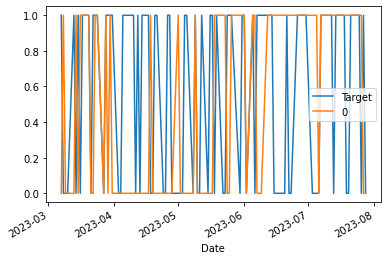

In [21]:
combined = pd.concat([test["Target"],preds], axis=1)
combined.plot()

In [26]:
def predict(train,test,pred,model):
    model.fit(train[pred],train["Target"])
    preds = model.predict(test[pred])
    preds = pd.Series(preds,index=test.index,name="Predictions")
    combined = pd.concat([test["Target"],preds],axis=1)
    return combined

In [25]:
def backtest(data, model, pred, start=2520, step=252):
    all_preds = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        preds = predict(train, test, pred, model)
        all_preds.append(preds)
    return pd.concat(all_preds)

In [27]:
predictions = backtest(spy, model, pred)

In [28]:
predictions["Predictions"].value_counts()

0    2606
1    2553
Name: Predictions, dtype: int64

In [29]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5483744614179397

In [30]:
predictions["Target"].value_counts()/predictions.shape[0]

1    0.550107
0    0.449893
Name: Target, dtype: float64

In [31]:
horizons = [2,5,60,252,1008]
new_pred = []

for horizon in horizons:
    roll_avg = spy.rolling(horizon).mean()

    ratio_col = f"Close_Ratio_{horizon}"
    spy[ratio_col] = spy["Close"]/ roll_avg["Close"]

    trend_col = f"Trend_{horizon}"
    spy[trend_col] = spy.shift(1).rolling(horizon).sum()["Target"]

    new_pred += [ratio_col,trend_col]

In [34]:
spy = spy.dropna()
spy

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_252,Trend_252,Close_Ratio_1008,Trend_1008
Date,,,,,,,,,,,,,,,,,
1997-01-24 00:00:00-05:00,48.717262,48.736811,48.013481,48.013481,2176000,47.876617,0,0.993528,0.0,0.985792,3.0,1.030367,37.0,1.135739,135.0,1.484298,532.0
1997-01-27 00:00:00-05:00,48.091661,48.316480,47.778870,47.876617,2108500,48.013481,1,0.998573,0.0,0.985830,2.0,1.025892,37.0,1.131487,134.0,1.479038,531.0
1997-01-28 00:00:00-05:00,48.560866,48.697712,47.544294,48.013481,4376000,48.482651,1,1.001427,1.0,0.992564,2.0,1.027389,37.0,1.133726,134.0,1.482233,531.0
1997-01-29 00:00:00-05:00,48.091662,48.482651,47.915717,48.482651,1122700,49.108234,1,1.004862,2.0,1.005759,2.0,1.035753,38.0,1.143794,134.0,1.495665,531.0
1997-01-30 00:00:00-05:00,48.717245,49.127784,48.424003,49.108234,2126300,49.049591,0,1.006410,2.0,1.016757,3.0,1.047301,38.0,1.157478,134.0,1.513877,531.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-21 00:00:00-04:00,453.959991,454.170013,452.170013,452.179993,71245400,454.200012,1,1.000000,0.0,0.998371,3.0,1.057881,34.0,1.130339,124.0,1.226334,545.0
2023-07-24 00:00:00-04:00,453.369995,455.040009,452.299988,454.200012,54023400,455.440002,1,1.002229,1.0,1.001345,3.0,1.060484,35.0,1.134693,124.0,1.231232,545.0
2023-07-25 00:00:00-04:00,453.920013,456.739990,453.869995,455.440002,55191200,455.510010,1,1.001363,2.0,1.003525,3.0,1.061539,35.0,1.137039,125.0,1.234015,545.0


In [35]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [36]:
def predict(train,test,pred,model):
    model.fit(train[pred],train["Target"])
    preds = model.predict_proba(test[pred])[:,1]
    preds[preds>= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds,index=test.index,name="Predictions")
    combined = pd.concat([test["Target"],preds],axis=1)
    return combined

In [37]:
predictions = backtest(spy, model, new_pred)

In [38]:
predictions["Predictions"].value_counts()

0.0    3581
1.0     569
Name: Predictions, dtype: int64

In [39]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5430579964850615